In [1]:
# Studying transverse resolution of EOS-BPM
# Python modules
from importlib import reload as rel;
import matplotlib.pyplot as plt;
import numpy as np;
from scipy.constants import c, epsilon_0;
from time import time;
eps0 = epsilon_0;
#from scipy.interpolate import interp1d;
import sys;
sys.path.insert(0, "../../python");
sys.path.insert(0, "..\\..\\python");
# Custom modules
from crystal import crystal;
from ebeam import ebeam;
from laser import laser;
import phase_retard as pr;
from plotting import makefig;
import thz;
import vertical_resolution as vr;

In [2]:
# Bunch parameters
################################################################################
Q_drive = 1.5e-9;
Q_wit   = 0.5e-9;
sigz    = 5.2e-6;
sigt    = sigz / c;
del_z   = 150e-6;
del_t   = del_z / c;
N       = 8000;
t_beams = np.linspace(-N * sigt / 2, N * sigt / 2, N);
drive   = ebeam({'Q' : Q_drive, 'sigz' : sigz, 'del_z' : 0, 't' : t_beams});
wit     = ebeam({'Q' : Q_wit, 'sigz' : sigz, 'del_z' : del_z, 't' : t_beams});
################################################################################
# Crystal parameters
ctype = 'GaP';
d     = 100e-6;
x     = 1e-2;
y     = 1e-2;
nx    = 1000;
ny    = 1000;
x0    = [4.0e-3, 0.0e-3]
y0    = [2e-3, 0];
x_arr = np.linspace(0, x, nx);
y_arr = np.linspace(-y/2, y/2, ny);
################################################################################
# Probe laser
lambda0 = 800e-9;
dy = 27e-9;
tp = 30e-15;
psi = 15;
psi_rad = psi * np.pi / 180;
probe = laser({'y0' : lambda0, 'dy' : dy, 'tp' : tp})
td    = 6e-12;

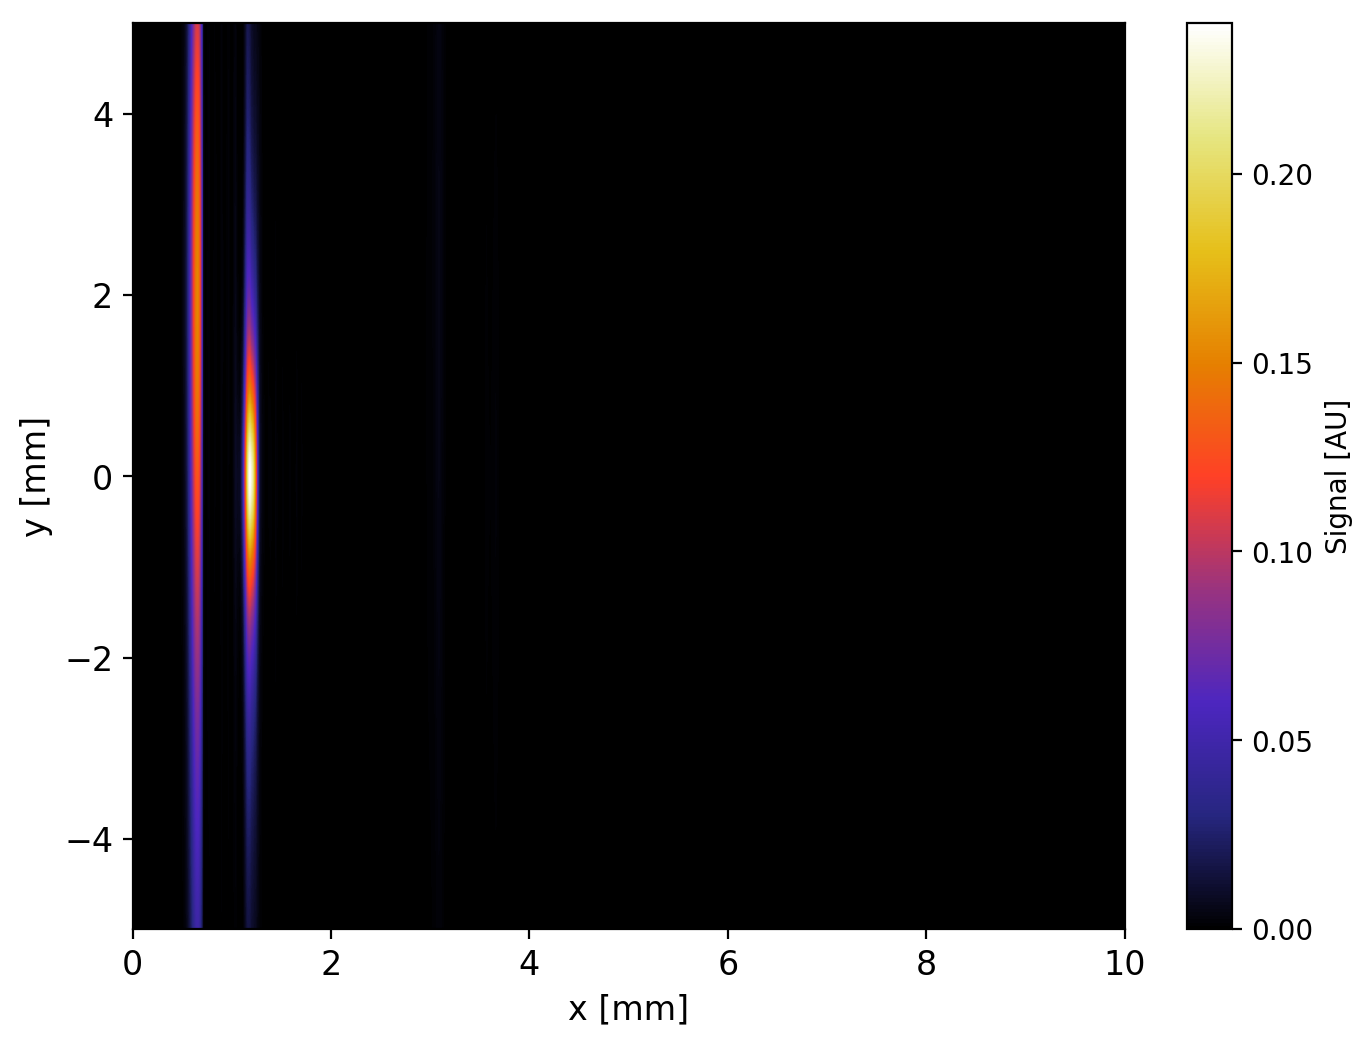

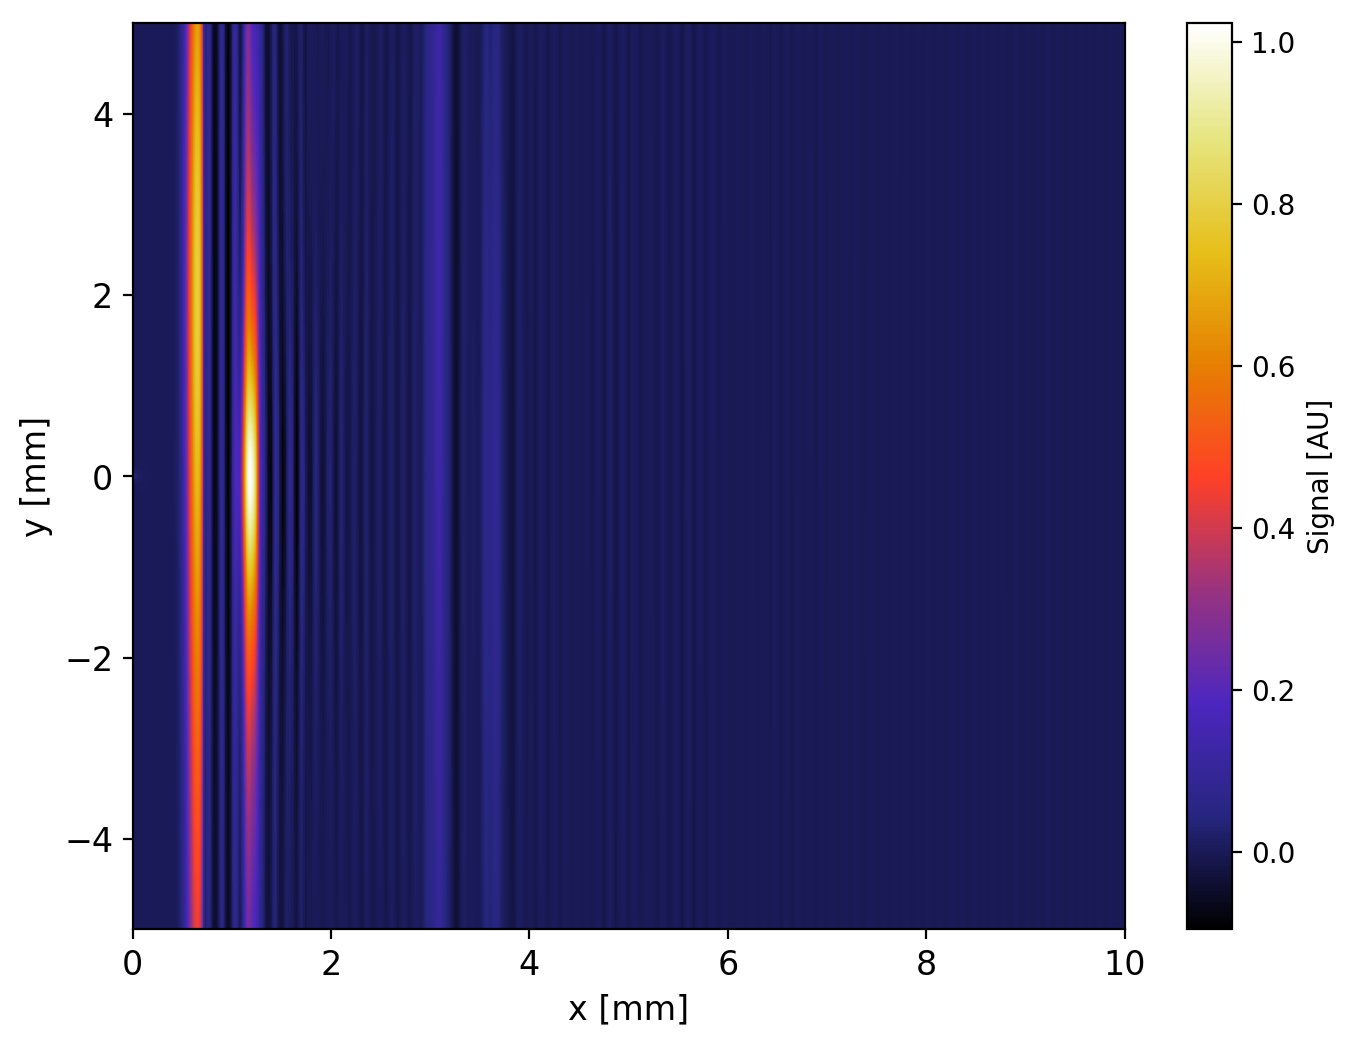

In [3]:
g_drive, g_wit, gma = vr.get_2D_signal(drive, wit, probe, psi, ctype, d, x0, x, y0, y, td, sweep = 'horizontal');
ext = np.array([min(x_arr), max(x_arr), min(y_arr), max(y_arr)]) * 1e3
sig2d = np.sin(gma / 2)**2
vr.plot_2D_sig(sig2d, ext);
vr.plot_2D_sig(gma, ext);

In [12]:
dys = np.array([0, 100, 500, 1000]) * 1e-6;
sig = np.zeros((len(y_arr), len(dys)));
for i in range(len(dys)):
    print(i + 1, "of", len(dys))
    y0 = [0, dys[i]];
    g_drive, g_wit, gma = vr.get_2D_signal(drive, wit, probe, psi, ctype, d, x0, x, y0, y, td, sweep = 'horizontal');
    sig2d = np.sin(gma / 2)**2;
    sig[:, i] = np.sum(sig2d, axis = 0);
    #print(y_arr[np.argmax(sig[:, i])])

1 of 4
2 of 4
3 of 4
4 of 4


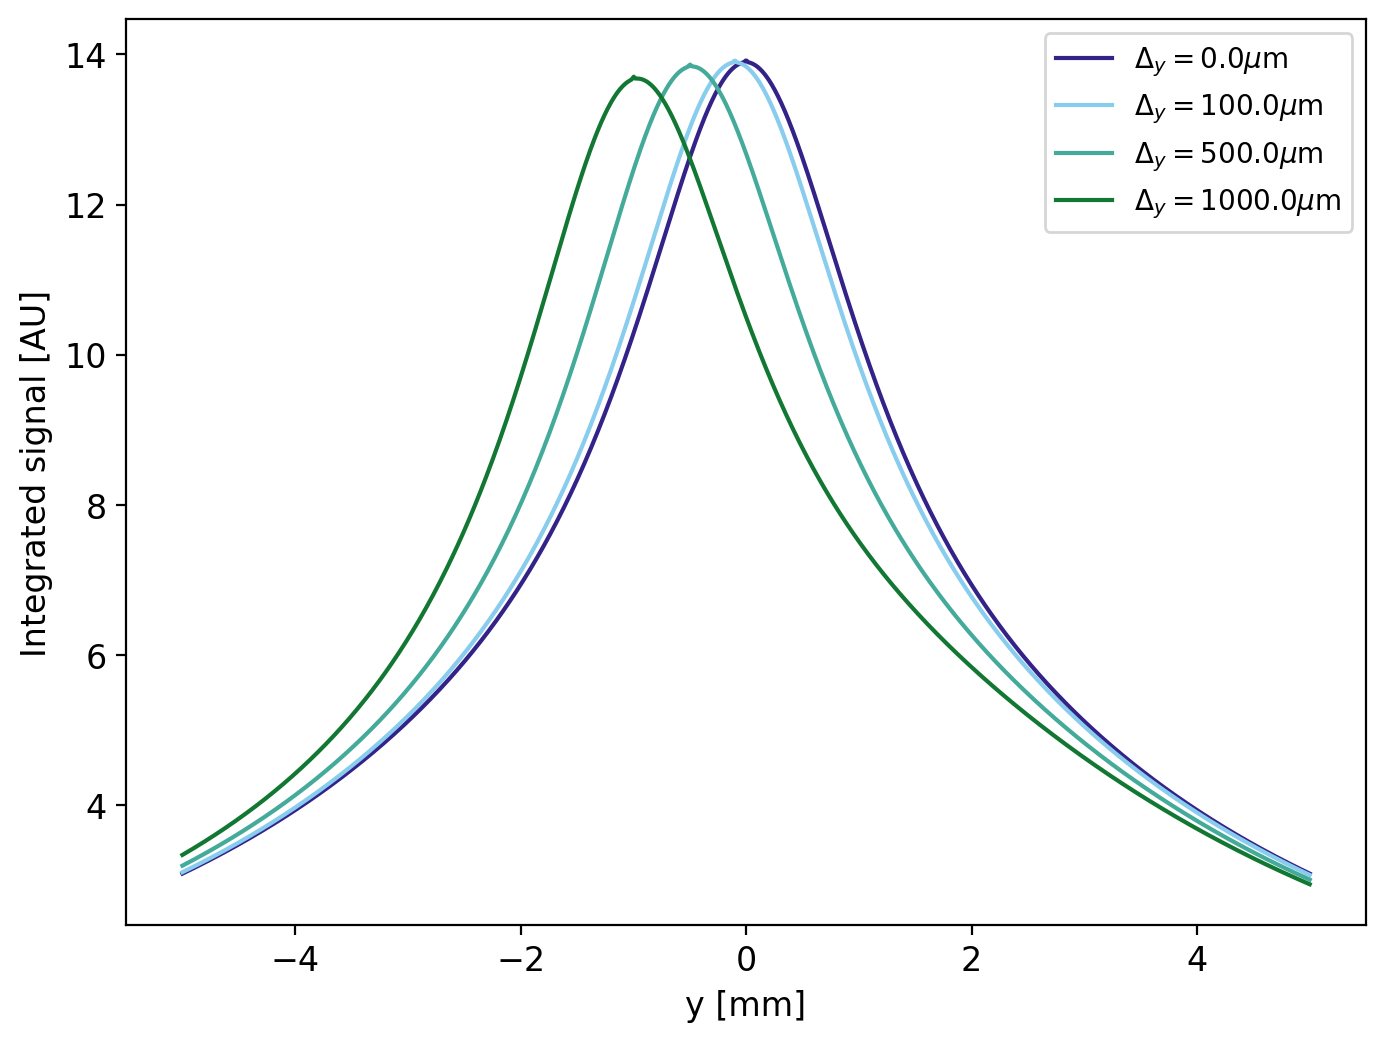

In [13]:
fig, ax = makefig(x = 8, y = 6, xlab = 'y [mm]', ylab = 'Integrated signal [AU]')
for i in range(len(dys)):
    lab = r'$\Delta_y = $' + str(np.round(dys[i]*1e6)) + r'$\mu$m'; 
    ax.plot(y_arr * 1e3, sig[:, i]*3, label = lab);
ax.legend();
plt.show();

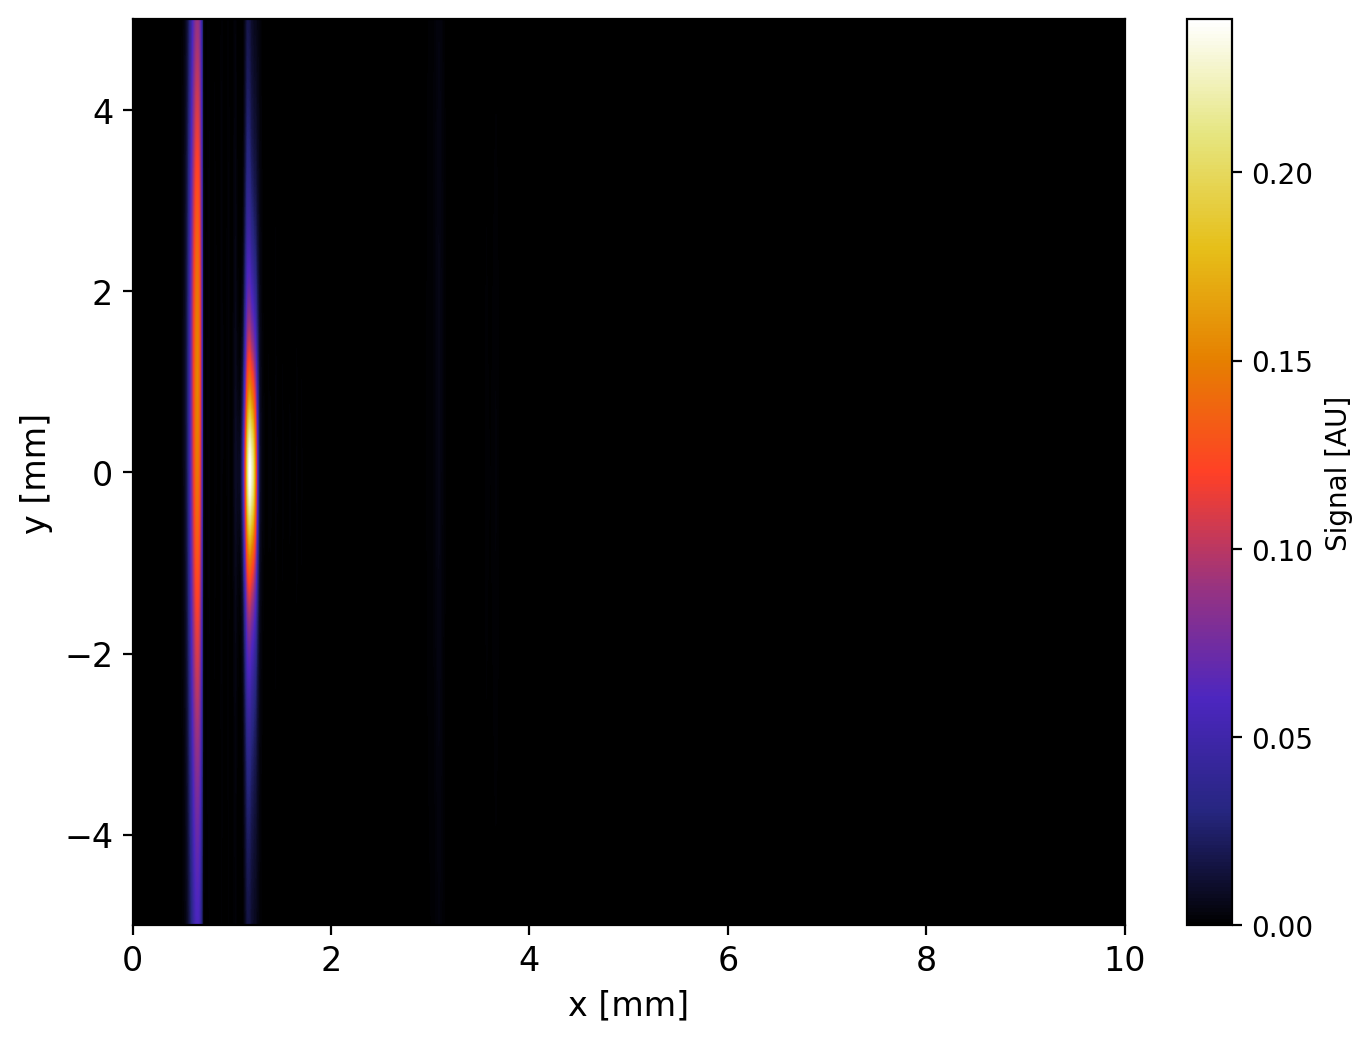

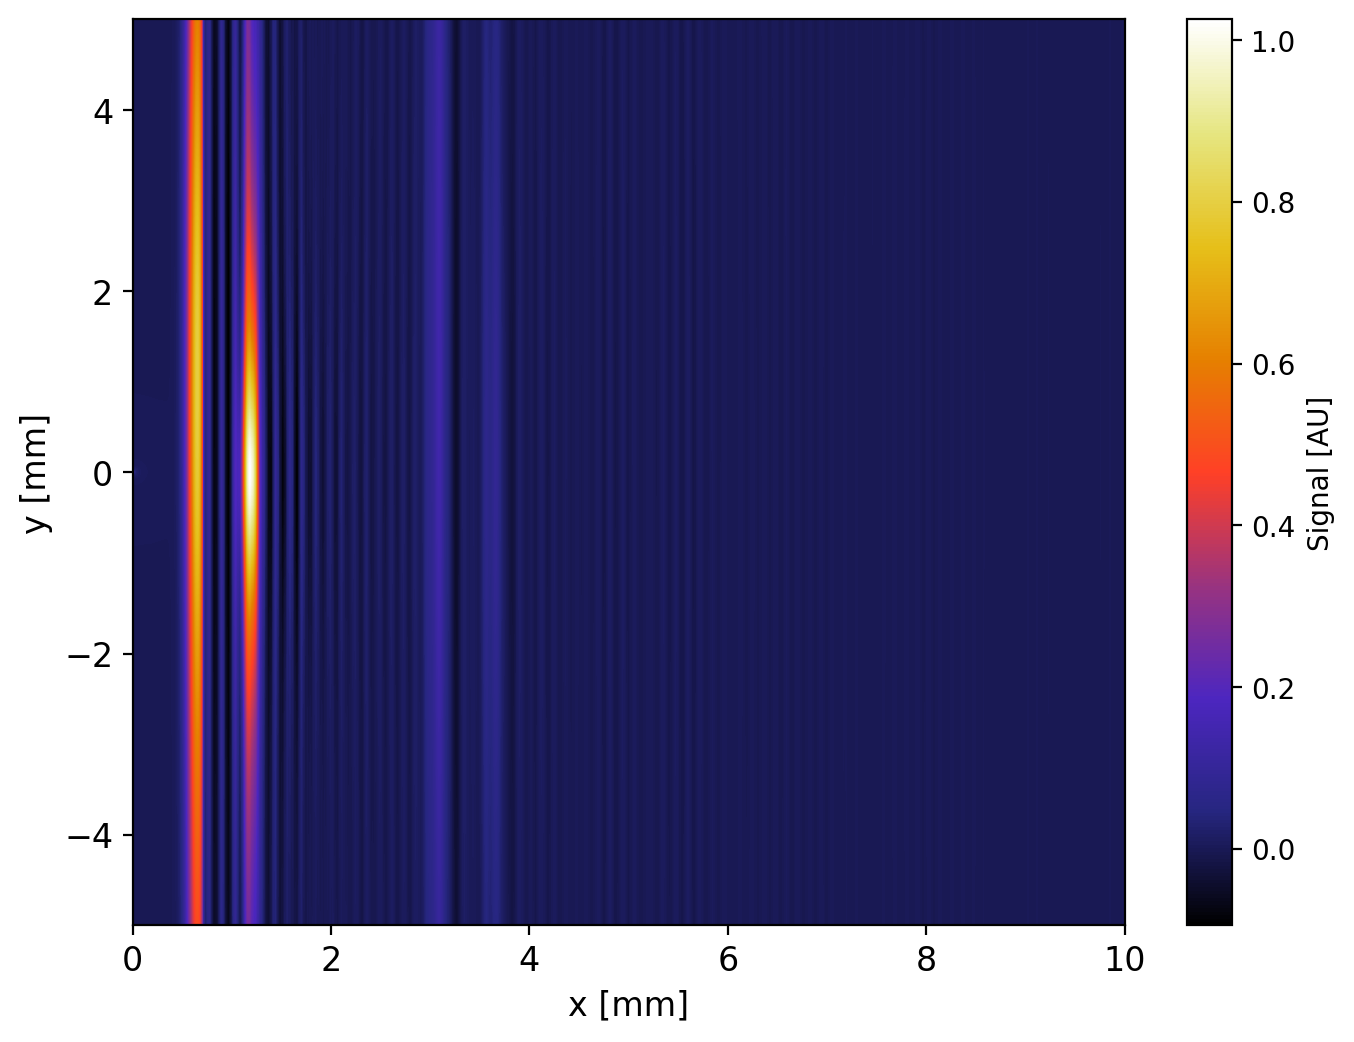

In [13]:
ext = np.array([min(x_arr), max(x_arr), min(y_arr), max(y_arr)]) * 1e3
vr.plot_2D_sig(sig2d, ext);
vr.plot_2D_sig(gma, ext);

In [4]:
vr = rel(vr);
g_drive, g_wit, gma = vr.get_2D_signal(drive, wit, probe, psi, ctype, d, x0, x, y0, y, td, sweep = 'horizontal');

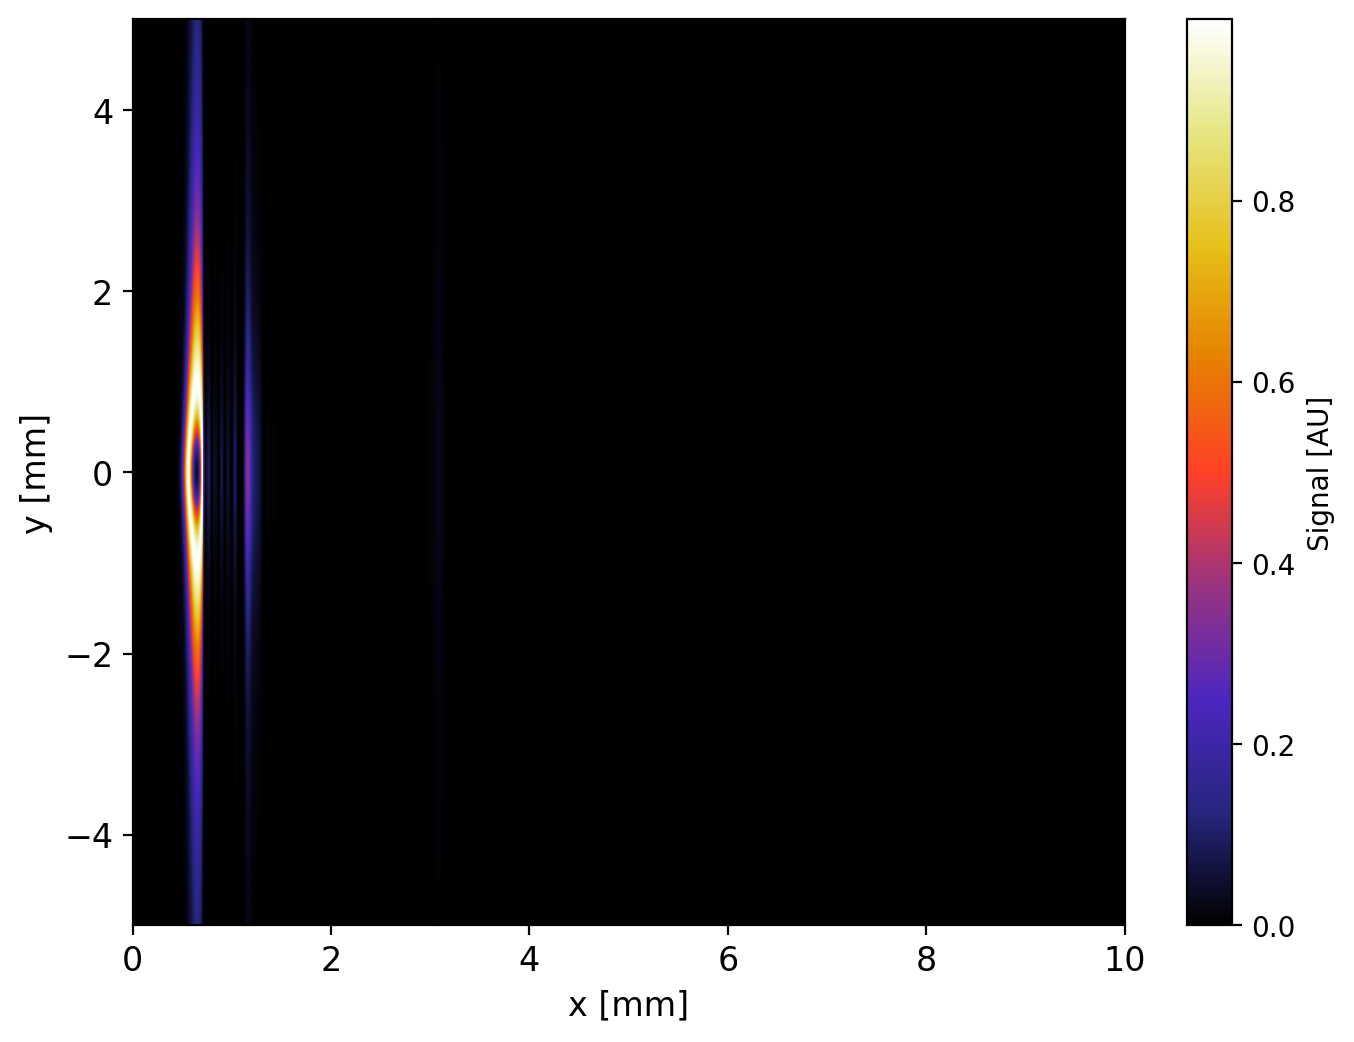

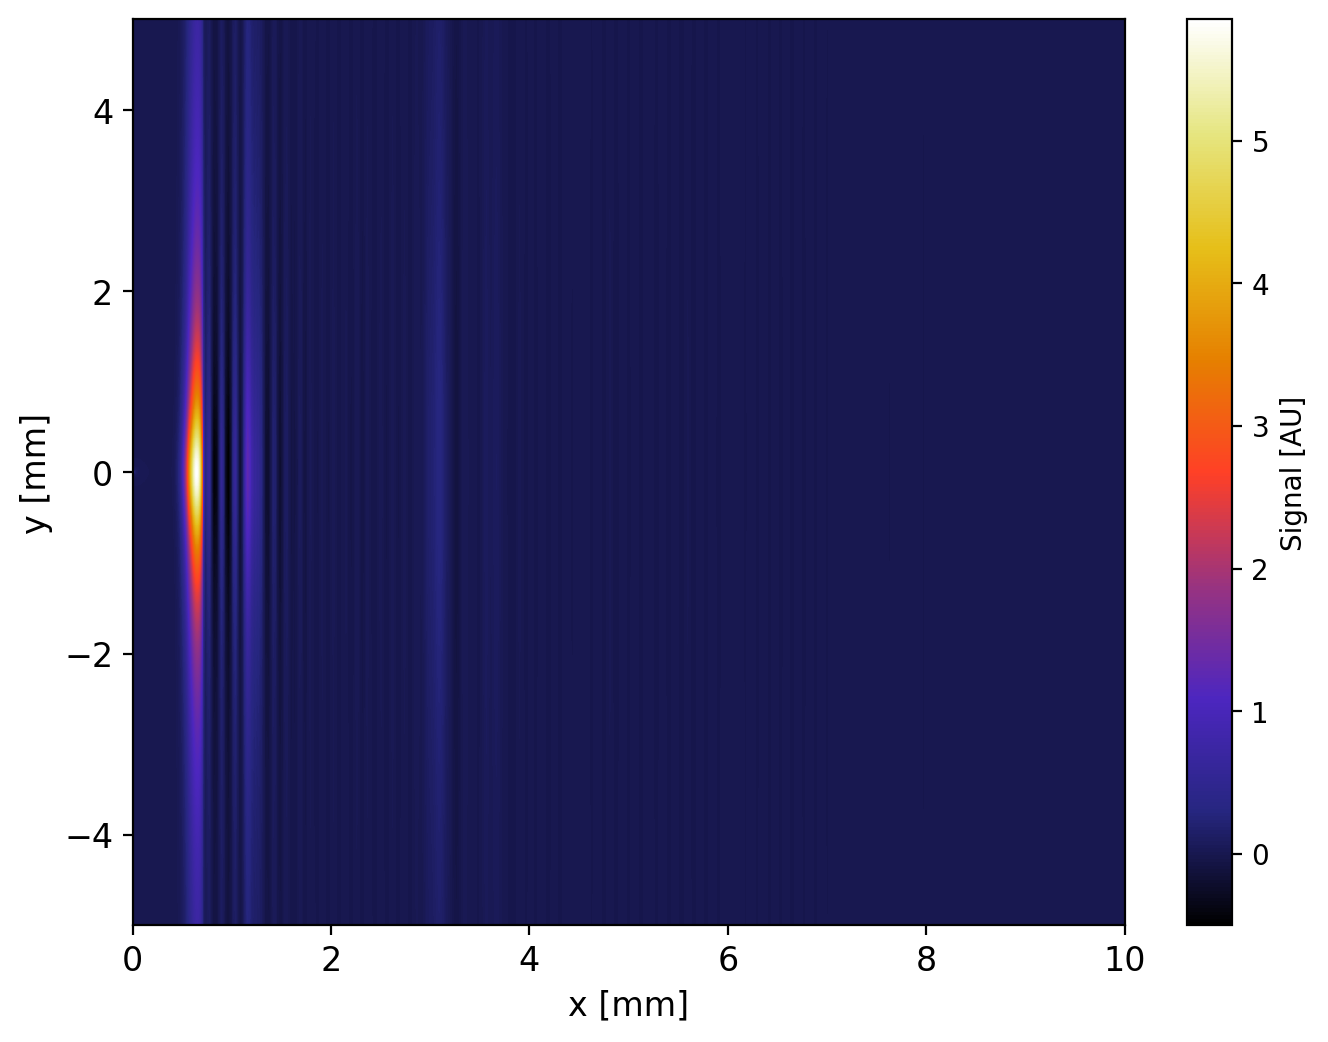

In [5]:
sig = np.sin(gma / 2)**2;
ext = np.array([min(x_arr), max(x_arr), min(y_arr), max(y_arr)]) * 1e3
vr.plot_2D_sig(sig, ext);
vr.plot_2D_sig(gma, ext);

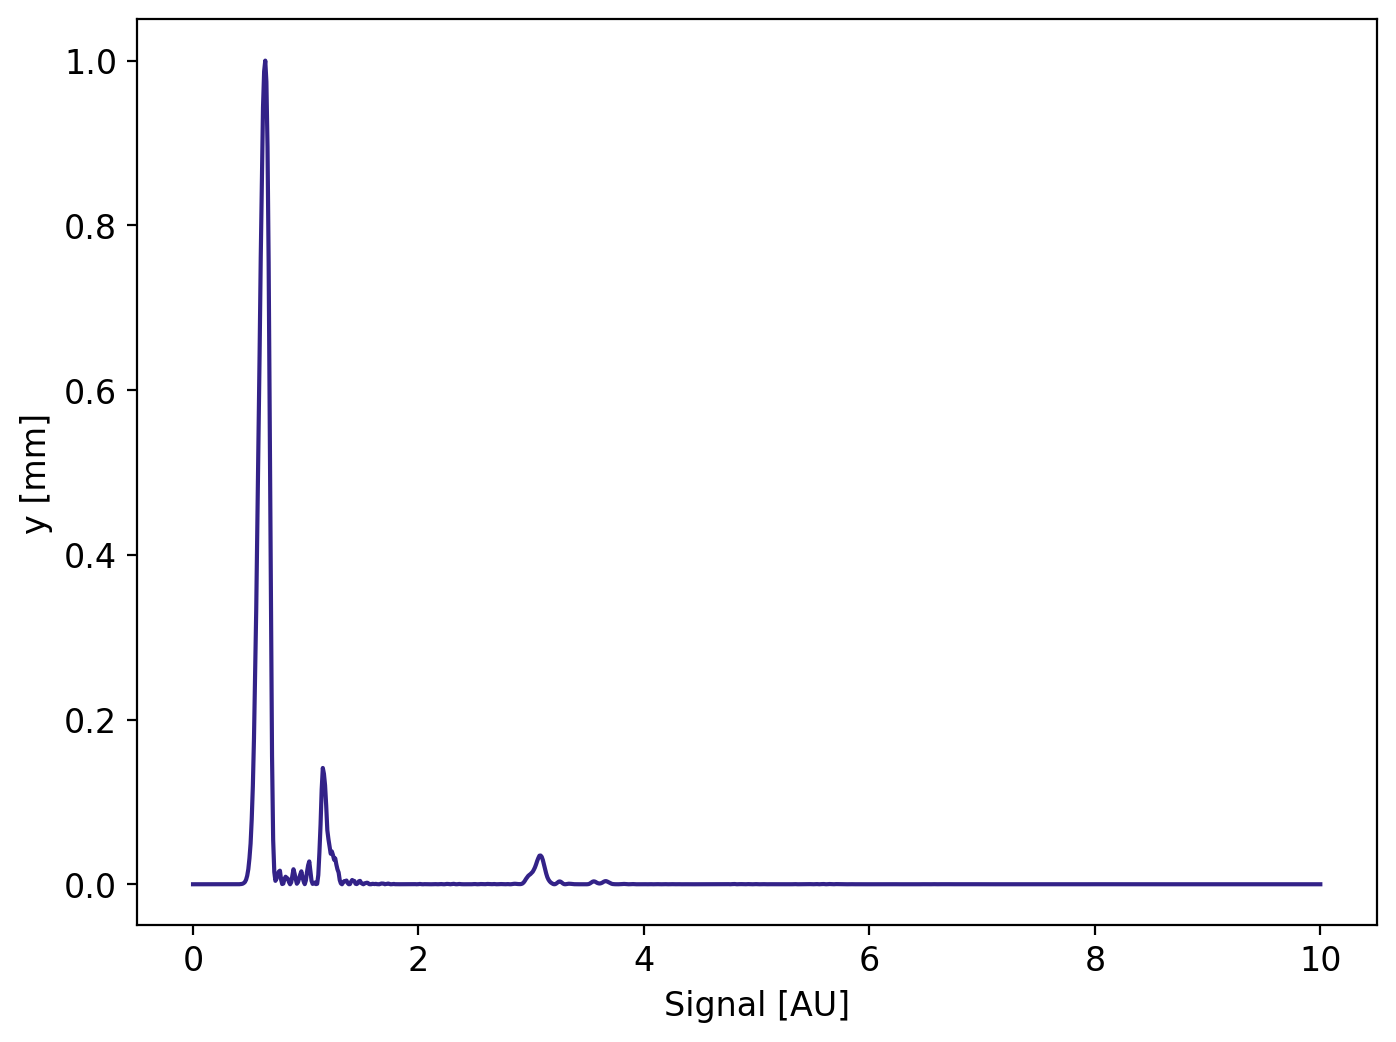

In [17]:
int_sig = np.sum(sig, axis = 1);
fig, ax = makefig(x = 8, y = 6, xlab = 'Signal [AU]', ylab = 'y [mm]')
ax.plot(x_arr * 1e3, int_sig / max(int_sig))
plt.show()

In [3]:
cry   = crystal(ctype);
x_arr = np.linspace(0, 1e-2, 1000);
y_arr = np.linspace(-5e-2, 5e-2, 1000);
t_delay = 6e-12
tau   = (x_arr / c) * np.tan(psi_rad) #+ t_delay;
Et_drive = np.exp(-(drive.t**2) / (2 * drive.sigt**2));
FErt_drive, f_drive = thz.raw_field(Et_drive, drive.t);
Ect_drive, tt_drive = thz.cry_field(drive.t, FErt_drive, f_drive, d, probe, cry);

Et_wit = np.exp(-(wit.t + wit.del_t)**2 / (2 * wit.sigt**2));
FErt_wit, f_wit = thz.raw_field(Et_wit, wit.t);
Ect_wit, tt_wit = thz.cry_field(wit.t, FErt_wit, f_wit, d, probe, cry);


base_drive, dummy = pr.phase_retard(Ect_drive, tt_drive * 1e-12, d, tau + t_delay, probe, cry, 'spatial', psi = psi);
base_wit, dummy   = pr.phase_retard(Ect_wit, tt_wit * 1e-12, d, tau + t_delay, probe, cry, 'spatial', psi = psi);

In [21]:
gamma_drive = np.zeros((len(x_arr), len(y_arr)));
gamma_wit   = np.zeros((len(x_arr), len(y_arr)));
for i in range(len(x_arr)):
    x_in = [x_arr[i] + 1e-3, x_arr[i] + 1e-3];
    for j in range(len(y_arr)):
        y_in = [y_arr[j], y_arr[j]];
        r_drive  = np.sqrt(x_in[0]**2 + y_in[0]**2);
        r_wit    = np.sqrt(x_in[1]**2 + y_in[1]**2); 
        E0_drive = drive.Q / (2 * np.pi * eps0 * r_drive * \
                    np.sqrt(2 * np.pi) * c * drive.sigt);
        E0_wit   = wit.Q / (2 * np.pi * eps0 * r_wit * \
                  np.sqrt(2 * np.pi) * c * wit.sigt);
        gamma_drive[i, j] = base_drive[i] * E0_drive;
        #gamma_wit[i, :]   = base_wit[i] * E0_wit

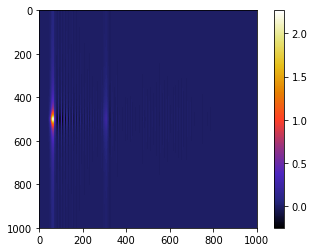

In [23]:
sig = gamma_drive #+ gamma_wit;
#sig = np.sin(sig / 2)**2
plt.imshow(np.transpose(sig), cmap = 'CMRmap');
plt.colorbar()
plt.show()

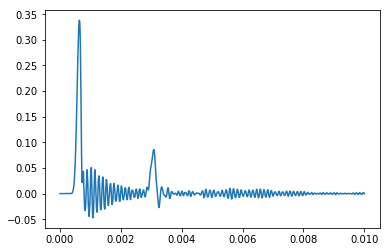

In [9]:
plt.plot(x_arr, gamma_drive[:, 500])
plt.show()

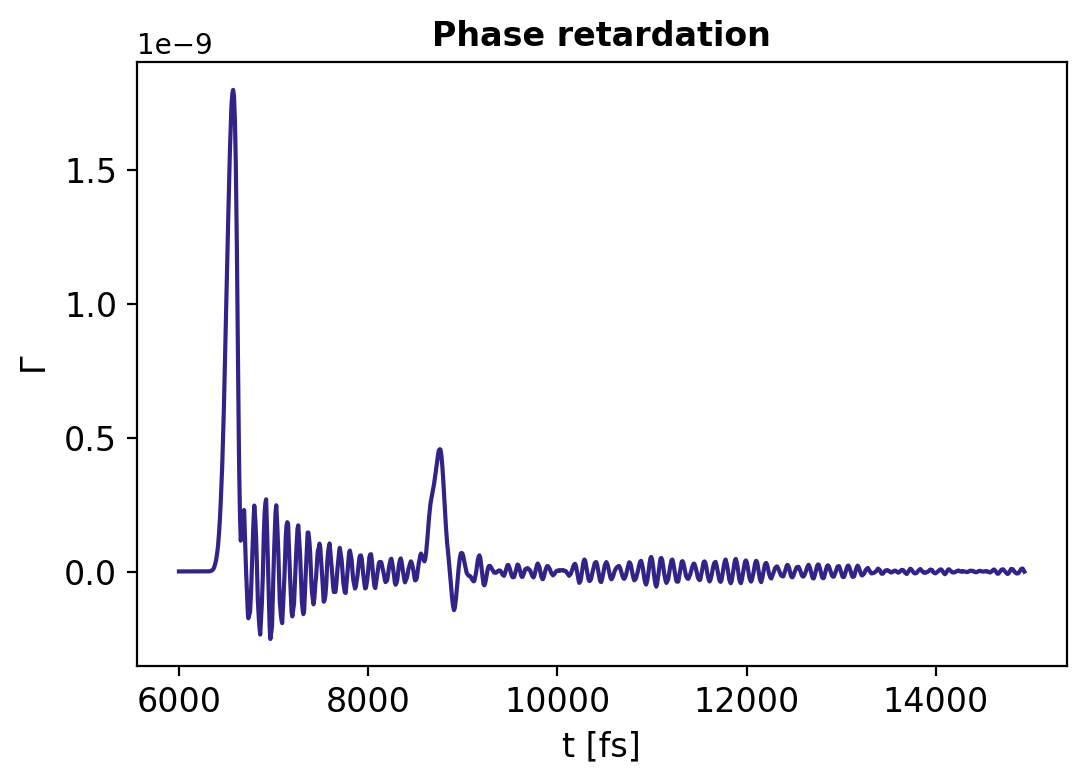

In [30]:
vr = rel(vr);
gamma_drive, gamma_wit, gamma = vr.get_2D_signal(drive, wit, probe, psi,\
                                              ctype, d, x0, x, y0, y,\
                                              nx = nx, ny = ny, sweep = 'horizontal');

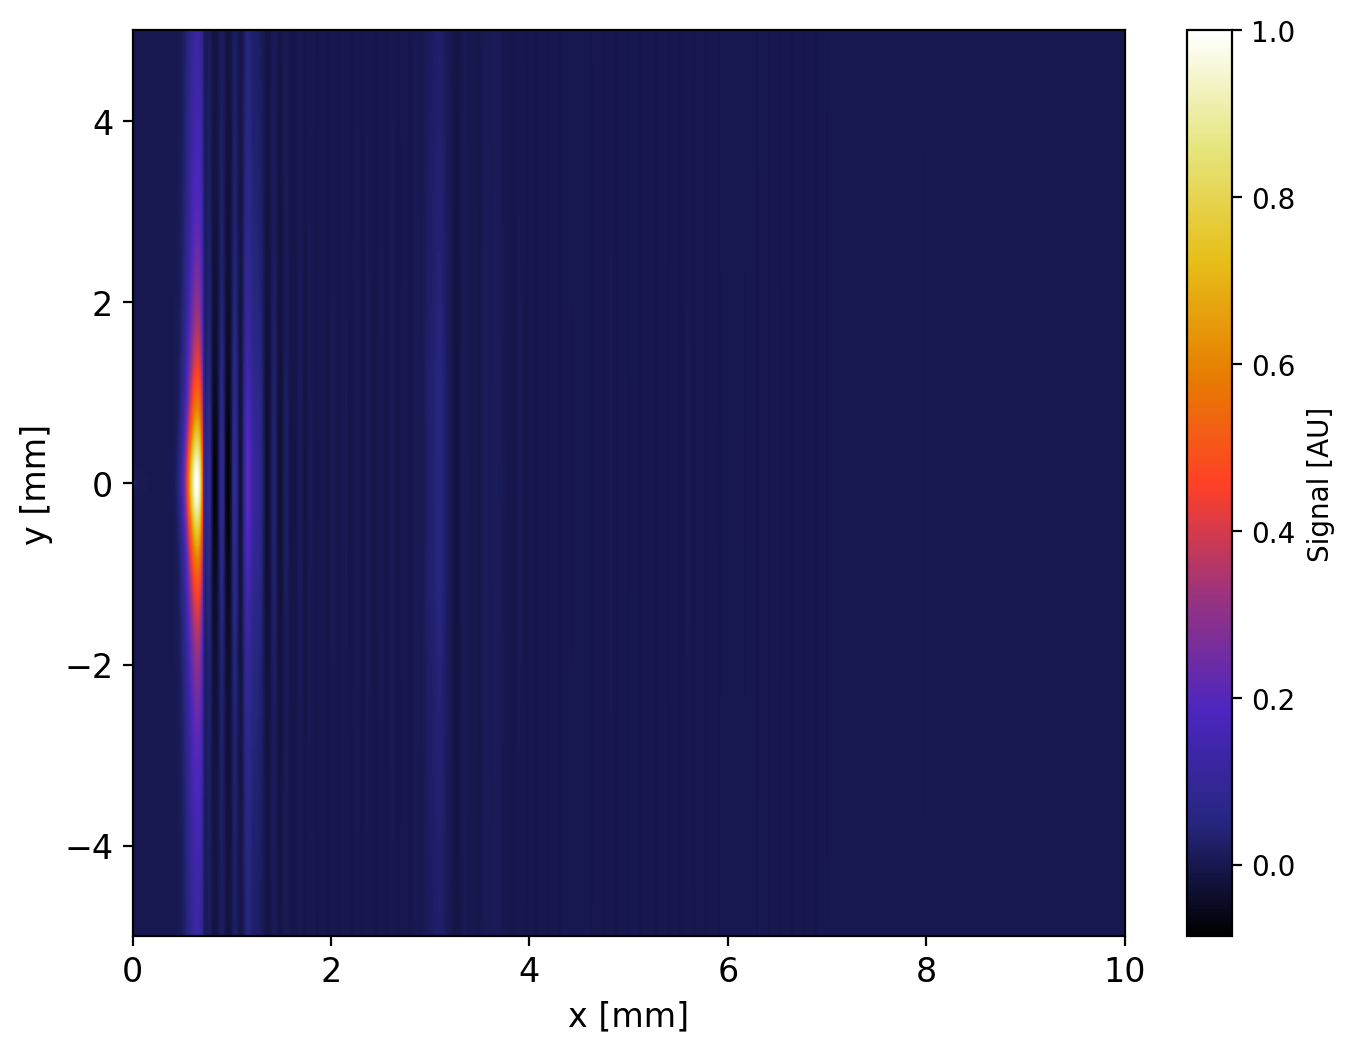

In [12]:
vr = rel(vr)
ext = [0, 10, -5, 5];
#sig = np.sin(gamma / 2)**2;
sig = gamma;
vr.plot_2D_sig(sig, ext);   

In [8]:
x_arr

array([0.00000000e+00, 1.00100100e-05, 2.00200200e-05, 3.00300300e-05,
       4.00400400e-05, 5.00500501e-05, 6.00600601e-05, 7.00700701e-05,
       8.00800801e-05, 9.00900901e-05, 1.00100100e-04, 1.10110110e-04,
       1.20120120e-04, 1.30130130e-04, 1.40140140e-04, 1.50150150e-04,
       1.60160160e-04, 1.70170170e-04, 1.80180180e-04, 1.90190190e-04,
       2.00200200e-04, 2.10210210e-04, 2.20220220e-04, 2.30230230e-04,
       2.40240240e-04, 2.50250250e-04, 2.60260260e-04, 2.70270270e-04,
       2.80280280e-04, 2.90290290e-04, 3.00300300e-04, 3.10310310e-04,
       3.20320320e-04, 3.30330330e-04, 3.40340340e-04, 3.50350350e-04,
       3.60360360e-04, 3.70370370e-04, 3.80380380e-04, 3.90390390e-04,
       4.00400400e-04, 4.10410410e-04, 4.20420420e-04, 4.30430430e-04,
       4.40440440e-04, 4.50450450e-04, 4.60460460e-04, 4.70470470e-04,
       4.80480480e-04, 4.90490490e-04, 5.00500501e-04, 5.10510511e-04,
       5.20520521e-04, 5.30530531e-04, 5.40540541e-04, 5.50550551e-04,
      

In [5]:
#gamma_new = base_drive * E0_drive + base_wit * E0_wit;
#gamma_old = gamma_drive + gamma_wit;

#plt.plot(tau, np.sin(gamma_old / 2)**2, '-b');
#plt.plot(tau, np.sin(gamma_new / 2)**2, '--r');
#plt.show()

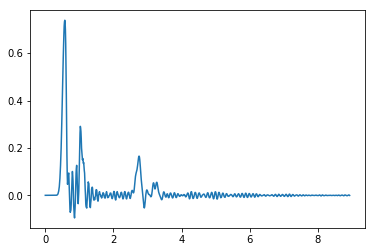

In [13]:
line_sig = sig[:, 0];
plt.plot(x_arr / c * np.tan(psi_rad) * 1e12, line_sig);
plt.show();

1 of 3
2 of 3
3 of 3


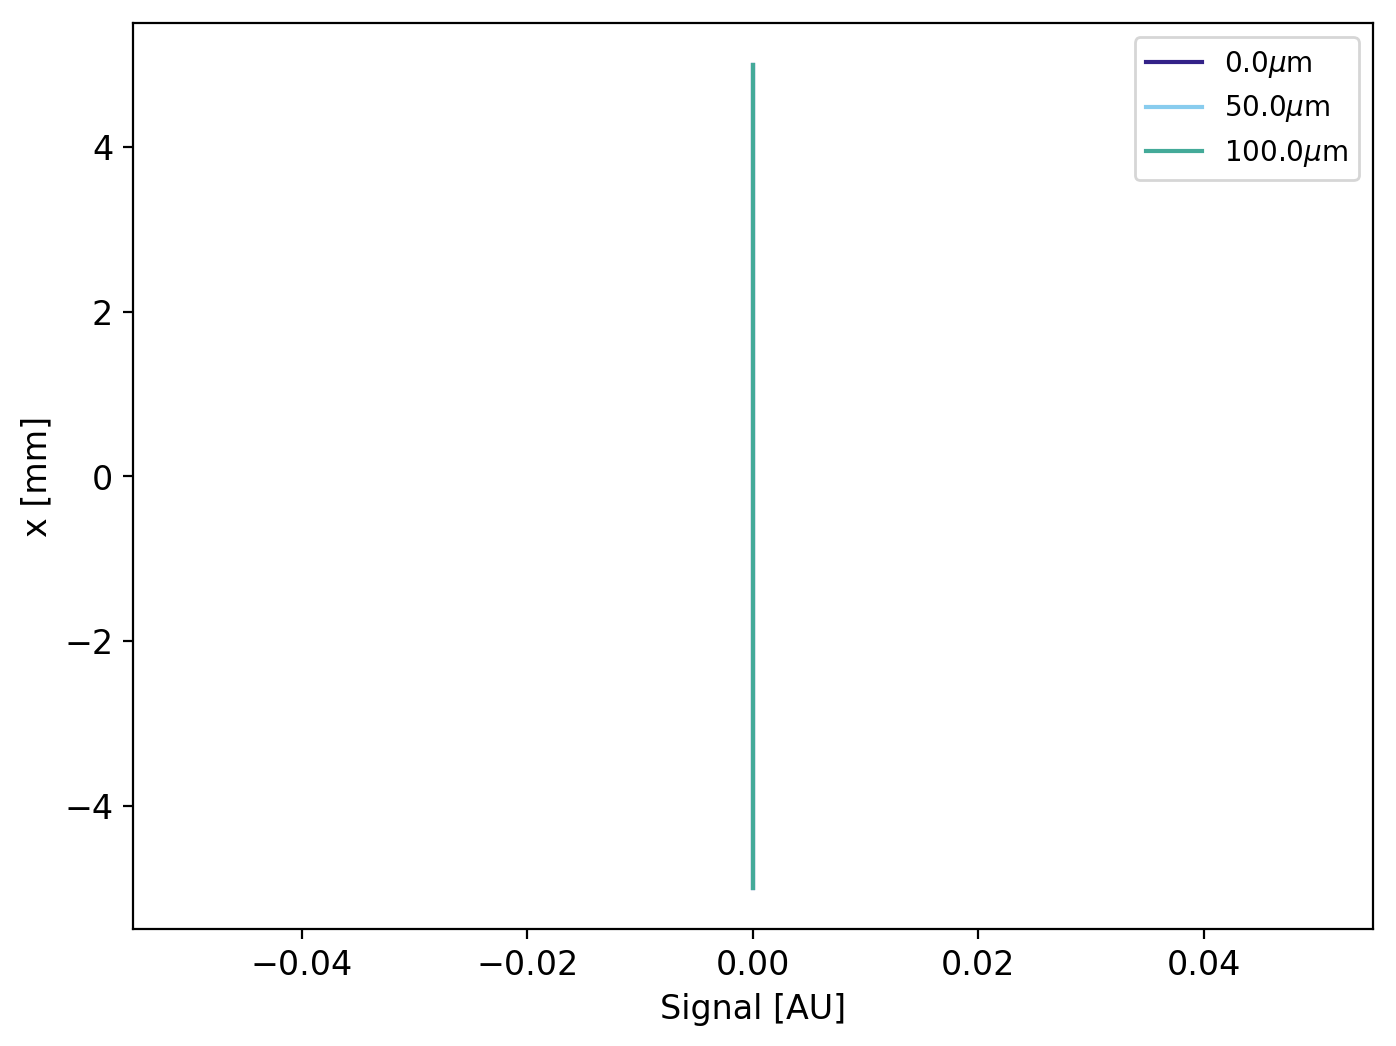

In [11]:
y_off = np.array([0, 50, 100]) * 1e-6;
fig, ax = makefig(x = 8, y = 6, xlab = 'Signal [AU]', ylab = 'x [mm]');
x_arr = np.linspace(0, x, nx);
y_arr = np.linspace(-y/2, y/2, ny);
for i in range(len(y_off)):
    print(i + 1, "of", len(y_off))
    lab = str(np.round(y_off[i] * 1e6)) + r'$\mu$m';
    y0  = [0, y_off[i]];
    gamma_drive, gamma_wit, gamma = vr.get_2D_signal(drive, wit, probe, psi,\
                                              ctype, d, x0, x, y0, y,\
                                              nx = 1000, ny = 1000, sweep = 'vertical');
    sig = np.sin(gamma / 2)**2;
    int_sig = vr.integrate_1D(sig, x, y, 1, 5);
    ax.plot(int_sig, y_arr * 1e3, label = lab);
ax.legend();
plt.show();

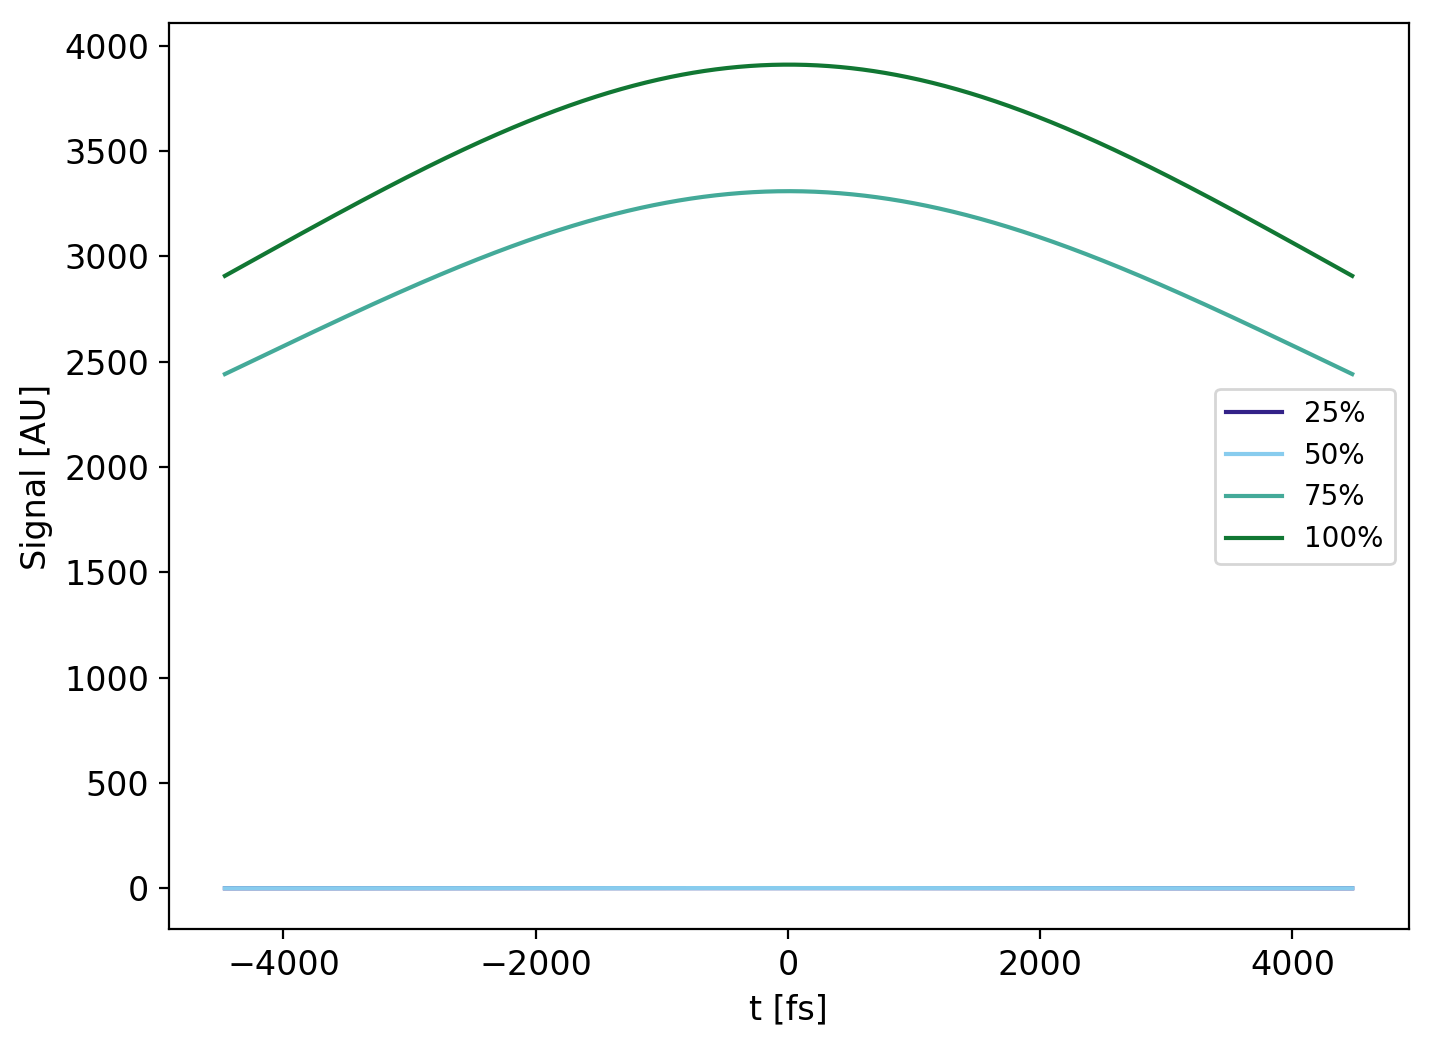

In [19]:
# Effect integration limits on witness relative peak
psi_rad = 15 * np.pi / 180;
ys    = np.array([2.5, 5, 7.5, 10]) * 1e-3;
labs  = np.array(['25%', '50%', '75%', '100%'])
x_arr = np.linspace(0, x, nx);
y_arr = np.linspace(0, y, ny);
tau   = (y_arr / c) * np.tan(psi * np.pi / 180);
y_arr = c * tau / (np.tan(psi_rad));
y_arr = y_arr - y_arr[int(len(y_arr) / 2 + 1)];
fig, ax = makefig(x = 8, y = 6, xlab = 't [fs]', ylab = 'Signal [AU]')
t_plot = tau * 1e15;
for i in range(len(ys)):
    int_sig = vr.integrate_1D(sig, x_arr, y_arr, 0, ys[i]);
    if i == 0:
        t_plot = t_plot - t_plot[np.argmax(int_sig)]
        norm = max(int_sig);
    ax.plot(t_plot, int_sig / norm, label = labs[i]);
ind = np.argmax(int_sig);
#xlims = [t_plot[ind] - 1000,t_plot[ind] + 1000]
ax.legend();
#ax.set_xlim(xlims)
plt.show()

In [ ]:
cry = crystal(ctype);
t_delay = 6e-12;
tau = (x_arr / c) * np.tan(psi_rad) + t_delay;
x_drive = 1e-3;
x_wit   = 1e-3;
y_drive = 5e-3;
y_wit   = 5e-3;

E0_drive, E0_wit = get_E0(drive, wit, [x_drive, x_wit], [y_drive, y_wit]);

Et_drive = np.exp(-(drive.t**2) / (2 * drive.sigt**2));
FErt_drive, f_drive = thz.raw_field(Et_drive, drive.t);
Ect_drive, tt_drive = thz.cry_field(drive.t, FErt_drive, f_drive, d, probe, cry);


Et_wit = np.exp(-(wit.t + wit.del_t)**2 / (2 * wit.sigt**2));
FErt_wit, f_wit = thz.raw_field(Et_wit, wit.t);
Ect_wit, tt_wit = thz.cry_field(wit.t, FErt_wit, f_wit, d, probe, cry);

Er_drive = E0_drive * np.exp(-(drive.t**2) / (2 * drive.sigt**2));
FEr_drive, f_drive = thz.raw_field(Er_drive, drive.t);
Ec_drive, tt_drive = thz.cry_field(drive.t, FEr_drive, f_drive, d, probe, cry);

Er_wit = E0_wit * np.exp(-(wit.t + wit.del_t)**2 / (2 * wit.sigt**2));
FEr_wit, f_wit = thz.raw_field(Er_wit, wit.t);
Ec_wit, tt_wit = thz.cry_field(wit.t, FEr_wit, f_wit, d, probe, cry);


base_drive, dummy = pr.phase_retard(Ect_drive, tt_drive * 1e-12, d, tau, probe, cry, 'spatial', psi = psi);
base_wit, dummy   = pr.phase_retard(Ect_wit, tt_wit * 1e-12, d, tau, probe, cry, 'spatial', psi = psi);

gamma_drive, dummy = pr.phase_retard(Ec_drive, tt_drive * 1e-12, d, tau, probe, cry, 'spatial', psi = psi);
gamma_wit, dummy   = pr.phase_retard(Ec_wit, tt_wit * 1e-12, d, tau, probe, cry, 'spatial', psi = psi);